In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint

In [2]:
iris = datasets.load_iris()
X = iris['data']
y = iris['target']

J = np.random.uniform(size=X.shape)
thresh = 0.2
J[J < thresh] = 0
J[J >= thresh] = 1

X.shape, J.shape, y.shape, set(y)


((150, 4), (150, 4), (150,), {0, 1, 2})

In [3]:
X_train, X_test, J_train, J_test, y_train, y_test = train_test_split(X, J, y, test_size=0.33, random_state=42)

In [4]:
ds_train = TensorDataset(
    torch.Tensor(X_train), 
    torch.Tensor(J_train),
    torch.Tensor(y_train).long()
)

ds_test = TensorDataset(
    torch.Tensor(X_test), 
    torch.Tensor(J_test),
    torch.Tensor(y_test).long()
)

batch_size=16
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size, shuffle=True)

In [5]:
class Reshaper(nn.Module):
    def __init__(self, out_size):
        super().__init__()

        self.out_size = out_size
        
    def forward(self, x):
        return x.view(*self.out_size)

In [6]:
class IrisInpainter(
    nn.Module
):
    def __init__(self, n_mixes: int = 1, in_size: int = 4, a_width = 3):
        super().__init__()

        
        self.extractor = nn.Sequential(
            nn.Linear(in_size * 2, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
        )
        
        self.a_extractor = nn.Sequential(
            nn.Linear(20, in_size * n_mixes * a_width),
            Reshaper((-1, n_mixes, a_width, in_size,)) # * L, we don't want 1x4 vector but L x4 matrix))
        )
        self.m_extractor = nn.Sequential(
            nn.Linear(20, n_mixes * in_size),
            Reshaper((-1, n_mixes, in_size))

        )
        
        self.d_extractor = nn.Sequential(
            nn.Linear(20, n_mixes * in_size),
            Reshaper((-1, n_mixes, in_size))

        )
        
        self.p_extractor = nn.Sequential(
            nn.Linear(20, n_mixes),
            nn.Softmax()
        ) # omit this, let's say p = 1 for now

    def forward(self, X, J):
        X_masked = X * J
        X_J = torch.cat([X_masked, J], dim=1)
        features = self.extractor(X_J)
        m = self.m_extractor(features)
        d = self.d_extractor(features)
        p = self.p_extractor(features)
        a = self.a_extractor(features)
        
        return  p, m, a, d

In [7]:

def nll_loss(X, J, P, M, A, D) -> torch.autograd.Variable:
    zipped = zip(X, J, P, M, A, D)
    losses = []
    
    
    for i, (x, j, p, m, a, d) in enumerate(zipped):
        mask_inds = (j==0).nonzero().squeeze()
        x_masked = torch.index_select(x, 0, mask_inds)
        a_masked = torch.index_select(a, 2, mask_inds)
        m_masked, d_masked = [
            torch.index_select(t, 1, mask_inds)
            for t in [m, d]
        ]
        
        for (p_i, m_i, d_i, a_i) in zip(p, m_masked, d_masked, a_masked):
            if a_i.shape[1] > 0:
                cov = (a_i.transpose(0,1) @ a_i) + torch.diag(d_i ** 2)
                mvn_d = dist.MultivariateNormal(m_i, cov) # calculate this manually
                l = - mvn_d.log_prob(x_masked) 
                losses.append(l)
            else:
                losses.append(torch.tensor(0.0, requires_grad=True)) #.cuda())
    return torch.stack(losses).mean()

  0%|          | 0/100 [00:00<?, ?it/s]/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


tensor(0.9555, grad_fn=<MeanBackward0>)


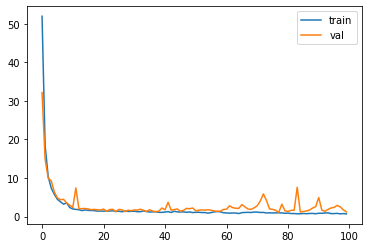

In [9]:
inpainter = IrisInpainter()
# inpainter = inpainter.cuda()
opt = optim.Adam(inpainter.parameters(), lr=4e-3)
n_epochs = 100
train_hist = []
val_hist = []
for e in tqdm(range(n_epochs)):
    inpainter.train()
    train_losses = [] 
    for i, (x, j, y) in enumerate(dl_train):
        inpainter.zero_grad()
#         x, j = x.cuda(), j.cuda()
        p, m, a, d = inpainter(x, j)
        loss = nll_loss(x, j, p, m, a, d)
        loss.backward()
        opt.step()
        train_losses.append(loss)
    train_hist.append(torch.stack(train_losses).mean())
    
    inpainter.eval()
    val_losses = []
    for i, (x, j, y) in enumerate(dl_test):
        inpainter.zero_grad()
#         x, j = x.cuda(), j.cuda()

        p, m, a, d = inpainter(x, j)
        loss = nll_loss(x, j, p, m, a, d)
        val_losses.append(loss)
    val_hist.append(torch.stack(val_losses).mean())

#     print(train_hist[-1], val_losses[-1])

plt.plot(list(range(n_epochs)), train_hist, label="train")
plt.plot(list(range(n_epochs)), val_hist, label="val")
plt.legend()
print(val_losses[-1])


In [10]:
classifier = MLPClassifier((10, 20, 10, 4), learning_rate_init=4e-3, max_iter=1000)
classifier.fit(X_train, y_train)
accuracy_score(classifier.predict(X_test), y_test)

0.98

In [11]:
X_test_masked = X_test * J_test
# X_test_masked[:, 0][J_test[:,0] == 0] = X_train[:,0].mean()
# X_test_masked[:, 1][J_test[:,1] == 0] = X_train[:,1].mean()
# X_test_masked[:, 2][J_test[:,2] == 0] = X_train[:,2].mean()
# X_test_masked[:, 3][J_test[:,3] == 0] = X_train[:,3].mean()


accuracy_score(classifier.predict(X_test_masked), y_test)
# print(X_train.mean(axis=0))
# X_test_masked

0.76

In [12]:
P_test, M_test, A_test, D_test = inpainter(torch.Tensor(X_test_masked), torch.Tensor(J_test))

X_test_inpainted = X_test_masked.copy()
X_test_inpainted[J_test == 0] = M_test.detach().cpu().numpy()[:, 0][J_test == 0]

# X_test_inpainted = M_test.detach().cpu().numpy()[:, 0]
print("X_test[0]", X_test[0]), 
print("X_test_masked[0]", X_test_masked[0]) 
print("M_test.detach().numpy()[0, 0]", M_test.detach().cpu().numpy()[0, 0]) 
print("X_test_inpainted[0]", X_test_inpainted[0])

accuracy_score(classifier.predict(X_test_inpainted), y_test)

X_test[0] [6.1 2.8 4.7 1.2]
X_test_masked[0] [6.1 2.8 0.  1.2]
M_test.detach().numpy()[0, 0] [3.5194266 2.2902582 4.3174076 1.1538798]
X_test_inpainted[0] [6.1        2.8        4.31740761 1.2       ]


/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.96

In [13]:
P_test, M_test, A_test, D_test = inpainter(torch.Tensor(X_test_masked), torch.Tensor(J_test))
#
nll_loss(torch.tensor(X_test).float(), torch.tensor(J_test).float(), P_test, M_test, A_test, D_test), 


/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(tensor(1.2720, grad_fn=<MeanBackward0>),)

In [16]:
A_test

tensor([[[[ 1.3005e+00,  7.2704e-02, -4.5100e-01, -5.2212e-02],
          [-2.7404e-01, -2.5629e-02, -5.2458e-01, -4.7878e-01],
          [-8.1538e-01, -2.5143e-02, -4.0545e-01, -3.0611e-01]]],


        [[[ 1.5902e+00,  5.3240e-02, -5.4854e-01, -5.3169e-02],
          [-3.7253e-01,  5.8783e-02, -6.6487e-01, -5.2126e-01],
          [-1.0240e+00, -4.7817e-02, -3.7985e-01, -3.2934e-01]]],


        [[[ 1.0396e+00,  2.9345e-01,  6.1209e-01,  7.5713e-01],
          [-6.5527e-01,  1.9479e-01, -1.7811e-01,  4.2216e-01],
          [-7.7358e-01,  1.2367e-01, -3.6835e-01, -1.0461e+00]]],


        [[[ 5.6902e-01,  3.6508e-01,  2.4951e-01,  5.3692e-01],
          [-1.7401e-01,  1.3008e-02, -1.7502e-01,  2.0281e-01],
          [-4.6677e-01, -6.7784e-03, -1.7177e-01, -7.1533e-01]]],


        [[[ 1.4137e+00,  5.3329e-02, -4.6394e-01, -6.2432e-02],
          [-3.1895e-01, -1.1904e-02, -5.5372e-01, -4.9782e-01],
          [-8.6999e-01, -5.1348e-03, -4.4724e-01, -3.3084e-01]]],


        [[[ 1.5308e+

In [61]:
nll_loss(torch.tensor(X_test).float(), torch.tensor(J_test).float(), P_test, torch.tensor(X_test).float().reshape(-1, 1, 4), A_test, D_test), 


(tensor(0.1227, grad_fn=<MeanBackward0>),)